In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import Unet2 as Unet
import roma
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import torchvision
import torch.nn.functional as F
def gauss_newton(x, residuals, damping=1., iterations=5):
    x_list = []
    # Unroll a number of iterations of Gauss-Newton.
    for i in range(0, iterations):
        # Compute the gauss-newton updates.
        # We cannot easily backpropagate through computing the Jacobian. However, we don't need to.
        # We can disconnect from the computation graph, and then re-attach at each iteration.
        with torch.no_grad():
            r = torch.atleast_1d(residuals(x))
            J = torch.nan_to_num(torch.atleast_2d(torch.autograd.functional.jacobian(residuals, x),100))
            # https://en.wikipedia.org/wiki/Gauss–Newton_algorithm
            u = torch.linalg.lstsq(J.T @ J, J.T @ r).solution
        # Update x, and in doing so, connect the update step to the computation graph.
        # This allows an outer optimization loop to compute the derivative of the loss with respect to the inputs.
        x = x - damping * u
        x_list.append(x)
    # return x
    return x_list
def backproject(depth, K):
    """
    Backproject a depth map into 3D space with normalized intrinsic matrix K.
    The depth map should be normalized between (min_depth, max_depth).
    """
    height, width = depth.shape[-2], depth.shape[-1]
    size = height * width
    y = torch.linspace(0, 1, height, device=depth.device)
    x = torch.linspace(0, 1, width,  device=depth.device)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=depth.device)
    points = torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)
    points = torch.linalg.inv(K) @ points
    return points * depth.view(-1, size, 1, 1)


def project(points, K, height, width, invert=False):
    coords = K @ points
    coords = perspective(coords)
    coords = coords.view(-1, height, width, 2)
    coords = (coords - 0.5) * 2
    return coords


def perspective(points):
    """
    Perspective division
    """
    return points[..., :-1, :] / (points[..., [-1], :] + 1e-7)


def transform(points, R,t, invert=False):
    """
    Project points to camera reference frame
    """
    # R, t = pose
    if invert:
        return R.mT @ (points - t)
    else:
        return R @ points + t


def disparity_to_depth(disparity, min_depth=0.1, max_depth=100.0):
    min_disparity = 1 / max_depth
    max_disparity = 1 / min_depth
    scaled = min_disparity + (max_disparity - min_disparity) * disparity
    depth = 1 / scaled
    return depth
def pix_coords(height, width, device):
    size = height * width
    y = torch.linspace(-1, 1, height, device=device)
    x = torch.linspace(-1, 1, width, device=device)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=device)
    # print("torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)", torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1))
    # x,y,z=depth 
    return torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)


def warp(homography, image, padding_mode="border"):
    height, width = image.shape[-2:]
    coords = pix_coords(height, width, device=device)
    warped = project(homography @ coords, height, width)

    warped = F.grid_sample(image, warped, padding_mode=padding_mode, align_corners=False)
    # print("gridsampled warped:", warped.shape)
    # backprojection 
    return warped


def reproject(depth, image, K, R, t):
    points_3d = backproject(depth, K)
    points_3d = transform(points_3d, R, t)
    points_2d = project(points_3d, K, depth.shape[-2], depth.shape[-1])
    output = F.grid_sample(image, points_2d, padding_mode="zeros", align_corners=False)
    return output


# def residuals(params):
#     """
#     Return the loss of aligning image_1 to image_0 with homography (params).
    
#     TODO: Replace the warp with backprojection (depth) and re-projection.
#     """
#     homography = params.view(3, 3)
#     warped = warp(homography, image_1)
#     output = ((image_0 - warped)**2).mean()
#     # use unet on homography -test
#     return output
    
def huber_norm(x,gamma):
    
    # print("Fdiff", Fdiff)
    abs_x = torch.abs(x)
    mask1 = abs_x <= gamma
    mask2 = abs_x > gamma
    mask1 = mask1.float()*0.5*(x**2)
    mask2 = mask2.float()*gamma*(abs_x-gamma/2)
    result = torch.sum(mask1+mask2)
    return result 

def residuals_depth(params):
    index = pyramid_level 
    
    # transform = params.view(3, 4)
    R_estimated = roma.rotvec_to_rotmat(params[:3].view(1,3)).float().view(3,3).to(device)
    T_estimated = params[3:].view(3, 1)
    # sampled = reproject(depth_0*1000, image_0, K, transform[:, :3], transform[:, -1:]).to(device)
    sampled = reproject(depth_query_inResidual*1000, image_query_inResidual, K.to(device), R_estimated, T_estimated).to(device)
    # output = ((image_1 - sampled)**2).mean()
    # feature map of F(u'), the reprojected image
    (F3_estimate,S3_estimate),(F2_estimate,S2_estimate),(F1_estimate,S1_estimate),(F0_estimate,S0_estimate) = net.forward(sampled)
    # feature map of F(u)
    (F3,S3),(F2,S2),(F1,S1),(F0,S0) = net.forward(image_r.to(device))
    F_list = [F0,F1,F2,F3]
    S_list = [S0,S1,S2,S3]
    F_estimate_list = [F0_estimate,F1_estimate,F2_estimate,F3_estimate]
    S_estimate_list = [S0_estimate,S1_estimate,S2_estimate,S3_estimate]

    # huber norm
    Fdiff = F_list[index]-F_estimate_list[index]

    norm = huber_norm(Fdiff,gamma)

    # return torch.sum(S3*S3_estimate*(F3-F3_estimate)**2)
    return torch.sum(S_list[index]*S_estimate_list[index]*(norm))


In [3]:
import matplotlib
import numpy as np

# Load the data
data = np.load('data_small.npz')
rgbs, depths, transforms, K_data = data['rgbs'], data['depths'], data['transforms'], data['K']
print("len(rgbs):", len(rgbs))
# Show the intrinsic matrix
print(K_data)

# Show the transform matrix for the first frame
# This is the exact result of calling rgb_camera.get_transform().get_matrix() in Carla
# Read about the Coordinate system used here:
# https://carla.readthedocs.io/en/latest/python_api/#carlarotation
print(transforms[0])

len(rgbs): 10
[[400.   0. 400.]
 [  0. 400. 300.]
 [  0.   0.   1.]]
[[-9.99944329e-01  1.03938282e-02 -1.82519504e-03 -1.92392654e+01]
 [-1.03938039e-02 -9.99945998e-01 -2.26101802e-05 -6.46948700e+01]
 [-1.82533148e-03 -3.63819959e-06  9.99998331e-01  1.99584389e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [4]:
test_im1 = torch.from_numpy(rgbs[0]).permute(2,0,1).unsqueeze(0).float()
test_im2 = torch.from_numpy(rgbs[1]).permute(2,0,1).unsqueeze(0).float()
test_depth1 = torch.from_numpy(depths[0]).unsqueeze(0).unsqueeze(0).float()
test_depth2 = torch.from_numpy(depths[1]).unsqueeze(0).unsqueeze(0).float()
test_extrinsic1 = torch.from_numpy(transforms[0]).float()
test_extrinsic2 = torch.from_numpy(transforms[1]).float()
K = torch.from_numpy(K_data).float()
K[0] = K[0] / 800
K[1] = K[1] / 600

In [5]:
def relative_transformation_carla(extrinsic1, extrinsic2):
    """
    Compute the relative transformation between two frames.
    """
    test_extrinsic1 = extrinsic1.clone()
    test_extrinsic2 = extrinsic2.clone()
    test_extrinsic1[[0,2],3] = test_extrinsic1[[2,0],3] # handness difference between intrinsic and carla extrinsic
    test_extrinsic2[[0,2],3] = test_extrinsic2[[2,0],3]
    # -1 the forward axis
    test_extrinsic1[2,3] = -test_extrinsic1[2,3]
    test_extrinsic2[2,3] = -test_extrinsic2[2,3]
    Tr1r2_Rotation = test_extrinsic2[:3,:3] @ torch.inverse(test_extrinsic1[:3, :3])
    Tr1r2_Translation = test_extrinsic2[:3,[-1]] - test_extrinsic1[:3,[-1]]
    return Tr1r2_Rotation,Tr1r2_Translation
Tr1r2_Rotation,Tr1r2_Translation = relative_transformation_carla(test_extrinsic1, test_extrinsic2)

In [6]:
transforms[0],test_extrinsic1
# transfrom[0] is original extrinsic matrix we got from carla
Tr1r2_Translation

tensor([[-5.9366e-05],
        [-3.2837e-02],
        [ 3.1471e+00]])

In [7]:
#try back projection on its self
test_reproject = reproject(test_depth1*1000, test_im1, K, Tr1r2_Rotation,Tr1r2_Translation)

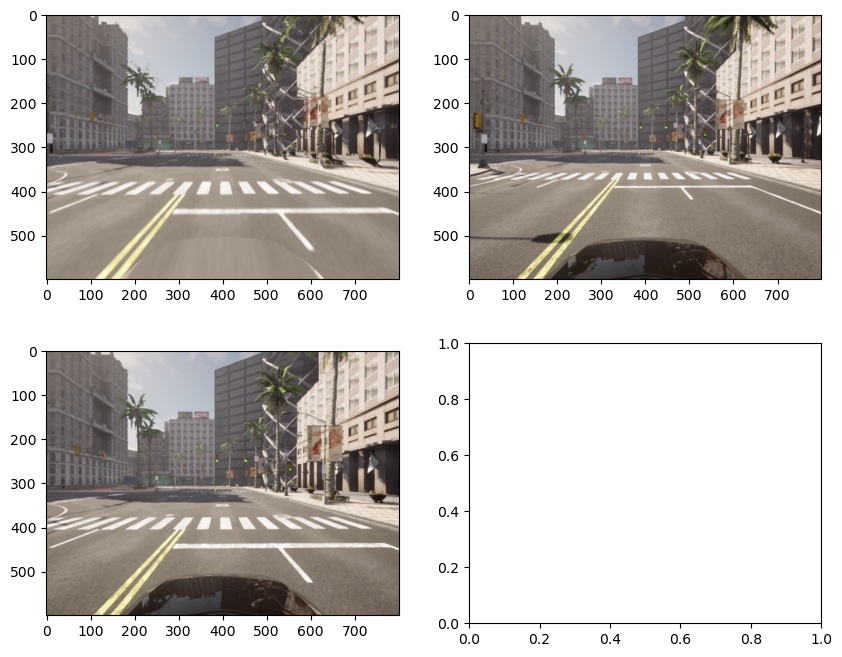

In [8]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].imshow(test_reproject.squeeze().permute(1,2,0)/255)
ax[1,0].imshow(test_im2.squeeze().permute(1,2,0)/255)
ax[0,1].imshow(test_im1.squeeze().permute(1,2,0)/255)

In [9]:
# call the network 
def consistency_loss(Tr0r1,Tqr_list,Tqr_final):
    # return huber_norm(Tr0r1@torch.inverse(Tqr1_k)@Tqr0,1)
    loss = 0
    if Tr0r1.shape != (3,4):
        Tr0r1 = Tr0r1.view(3,4)
    # Turn transfomation to 4*4 matrix
    Tr0r1 = torch.cat((Tr0r1,torch.tensor([0,0,0,1]).view(1,4).to(device)),0)
    # Tqr_final = torch.cat((Tqr_final.view(3,4),torch.tensor([0,0,0,1]).view(1,4).to(device)),0)
    Tqr_R = roma.rotvec_to_rotmat(Tqr_final[:3]).view(3,3)
    Tqr_T = Tqr_final[3:].view(3,1)
    Tqr_final = torch.cat((Tqr_R,Tqr_T),1)
    Tqr_final = torch.cat((Tqr_final,torch.tensor([0,0,0,1]).view(1,4).to(device)),0)
    for Tqr_k in Tqr_list:
        Tqr_k_R = roma.rotvec_to_rotmat(Tqr_k[:3]).view(3,3)
        Tqr_k_T = Tqr_k[3:].view(3,1)
        Tqr_k = torch.cat((Tqr_k_R,Tqr_k_T),1)
        Tqr_k = torch.cat((Tqr_k,torch.tensor([0,0,0,1]).view(1,4).to(device)),0)
        loss += huber_norm(Tr0r1@(torch.inverse(Tqr_k)@Tqr_final),1)

    return loss


In [10]:
#  randomly sample triplet of images

test_ref1_rgb = [0,3,9]
test_ref2_rgb = [1,4,8]
test_query_rgb = [2,5,6]


In [11]:
torch.autograd.set_detect_anomaly(False, check_nan=True)

In [12]:
import glob
import numpy as np
# import torch
class Carla_triple_Dataset(torch.utils.data.Dataset):
    def __init__(self, img_dir,size):
        # self.img_labels = img_dir
        self.img_dir = img_dir
        self.data = np.load(img_dir,mmap_mode='r')
        # self.rgbs,self.depths, self.transforms, self.K = data['rgbs'], data['depths'], data['transforms'], data['K']
        self.K = torch.from_numpy(self.data['K']).float().to(device)
        self.K[0] = self.K[0] / 800
        self.K[1] = self.K[1] / 600
        self.ref1_index = np.random.randint(low = 0, high = len(self.data['rgbs'])-1,size = (size,))
        self.ref2_index = self.ref1_index + 1
        l = np.arange(len(self.data['rgbs']))
        self.query_index = np.delete(l,np.unique(np.concatenate((self.ref1_index,self.ref2_index),0)))[:size]
        if len(self.query_index)<len(self.ref1_index):
            self.query_index = np.concatenate((self.query_index,np.random.choice(self.query_index,size = len(self.ref1_index)-len(self.query_index))))
        

    def __len__(self):
        # return len(self.img_labels)
        return len(self.ref1_index)
    # def coupling_ref_images(self):


    def __getitem__(self, idx):
        extrinsic1 = torch.from_numpy(self.data['transforms'][self.ref2_index[idx]]).float().to(device)
        extrinsic0 = torch.from_numpy(self.data['transforms'][self.ref1_index[idx]]).float().to(device)
        image_q = torch.from_numpy(self.data['rgbs'][self.query_index[idx]]).permute(2,0,1).float().to(device)#deleted unsuqeeze because dataloader added batch size
        image_0 = torch.from_numpy(self.data['rgbs'][self.ref1_index[idx]]).permute(2,0,1).float().to(device)
        image_1 = torch.from_numpy(self.data['rgbs'][self.ref2_index[idx]]).permute(2,0,1).float().to(device)

        depth_q = torch.from_numpy(self.data['depths'][self.query_index[idx]]).float().to(device)
        depth_0 = torch.from_numpy(self.data['depths'][self.ref1_index[idx]]).float().to(device)
        depth_1 = torch.from_numpy(self.data['depths'][self.ref2_index[idx]]).float().to(device)

        return image_0, image_1, image_q, depth_0, depth_1, depth_q, extrinsic0, extrinsic1

In [13]:
dataset = Carla_triple_Dataset('data_small.npz',2)

In [14]:
dataloader= torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [15]:
net = Unet.UNet(3,17).to(device)
net.train()

from torch.optim import Adam
loss_history = []
damp = torch.tensor(0.001, requires_grad=True)
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
net.train()
gamma = 0.02
for i,datas in enumerate(dataloader):
    lamdba_la = 10 if i == 0 else 1
    optimizer.learning_rate = 0.0001 if i == 0 else 0.00001

    loss = 0
    # set query image and 2 reference image
    # extrinsic0 = torch.from_numpy(transforms[test_ref1_rgb[i]]).float()
    # extrinsic1 = torch.from_numpy(transforms[test_ref2_rgb[i]]).float()
    # image_q = torch.from_numpy(rgbs[test_query_rgb[i]]).permute(2,0,1).unsqueeze(0).float().to(device)
    # image_0 = torch.from_numpy(rgbs[test_ref1_rgb[i]]).permute(2,0,1).unsqueeze(0).float().to(device)
    # image_1 = torch.from_numpy(rgbs[test_ref2_rgb[i]]).permute(2,0,1).unsqueeze(0).float().to(device)

    # depth_q = torch.from_numpy(depths[test_query_rgb[i]]).unsqueeze(0).float().to(device)
    # depth_0 = torch.from_numpy(depths[test_ref1_rgb[i]]).unsqueeze(0).float().to(device)
    # depth_1 = torch.from_numpy(depths[test_ref2_rgb[i]]).unsqueeze(0).float().to(device)
    image_0, image_1, image_q, depth_0, depth_1, depth_q, extrinsic0, extrinsic1 = datas
    # print("extrinsic0.shape", extrinsic0.shape)
    extrinsic0 = extrinsic0.view(4,4)
    extrinsic1 = extrinsic1.view(4,4)
    image_0 = image_0.view(3,800,600)
    image_1 = image_1.view(3,800,600)
    image_q = image_q.view(3,800,600)
    depth_0 = depth_0.view(1,800,600)
    depth_1 = depth_1.view(1,800,600)
    depth_q = depth_q.view(1,800,600)


    
    # Find Tr0r1, Tr0r1 @ r0 = r1 
    # R_r0r1 = torch.from_numpy(extrinsic1)[:3, :3] @ torch.inverse(torch.from_numpy(extrinsic0))[:3, :3]
    # t_r0r1 = torch.from_numpy(extrinsic1)[:3, -1] -  torch.from_numpy(extrinsic0)[:3, -1]
    R_r0r1, t_r0r1 = relative_transformation_carla(extrinsic0, extrinsic1)
    Tr0r1 = torch.cat((R_r0r1, t_r0r1.view(3, 1)), dim=1).to(device).float()
    # transofrmacy accuracy :

    K = K.to(device)
    # find Tq_r0, map image query to image r0 (now is image_0 to image 1)
    depth_query_inResidual = depth_q
    image_query_inResidual = image_q
    image_r = image_0
    # set inital guess as identity rot-vec. and 0 translation

    # for each pyramid level 1-4
    # F0, S0 level
    pyramid_level = 0 #800*600
    result_0_r0 = gauss_newton(torch.Tensor([0,0,0,0,0,0]).float().to(device), residuals_depth, iterations=4, damping=damp)
    # print("result_0_r0: ", result_0_r0)
    # F1, S1 level
    pyramid_level = 1 #400*300
    result_1_r0 = gauss_newton(torch.Tensor([0,0,0,0,0,0]).float().to(device), residuals_depth, iterations=8, damping=damp)
    # print("result_1_r0: ", result_1_r0)
    # F2, S2 level
    pyramid_level = 2 #200*150
    result_2_r0 = gauss_newton(torch.Tensor([0,0,0,0,0,0]).float().to(device), residuals_depth, iterations=12, damping=damp)
    # print("result_2_r0: ", result_2_r0)
    # F3, S3 level
    pyramid_level = 3
    result_3_r0 = gauss_newton(torch.Tensor([0,0,0,0,0,0]).float().to(device), residuals_depth, iterations=16, damping=damp)
    # print("result_3_r0: ", result_3_r0)
    
    # find Tq_r1, map image query to image r1 (now is image_1 to image 1)
    image_r = image_1
    # for each pyramid level 1-4
    # F0, S0 level
    pyramid_level = 0
    result_0_r1 = gauss_newton(torch.Tensor([0,0,0,0,0,0]).float().to(device), residuals_depth, iterations=4, damping=damp)
    # F1, S1 level
    pyramid_level = 1
    result_1_r1 = gauss_newton(torch.Tensor([0,0,0,0,0,0]).float().to(device), residuals_depth, iterations=8, damping=damp)
    # F2, S2 level
    pyramid_level = 2
    result_2_r1 = gauss_newton(torch.Tensor([0,0,0,0,0,0]).float().to(device), residuals_depth, iterations=12, damping=damp)
    pyramid_level = 3
    result_3_r1 = gauss_newton(torch.Tensor([0,0,0,0,0,0]).float().to(device), residuals_depth, iterations=16, damping=damp)

    lc_r0r1_0 = torch.nan_to_num(consistency_loss(Tr0r1,result_0_r0,result_0_r1[-1]),1)
    lc_r1r0_0 = torch.nan_to_num(consistency_loss(Tr0r1,result_0_r1,result_0_r0[-1]),1)
    lc_r0r1_1 = torch.nan_to_num(consistency_loss(Tr0r1,result_1_r0,result_1_r1[-1]),1)
    lc_r1r0_1 = torch.nan_to_num(consistency_loss(Tr0r1,result_1_r1,result_1_r0[-1]),1)
    lc_r0r1_2 = torch.nan_to_num(consistency_loss(Tr0r1,result_2_r0,result_2_r1[-1]),1)
    lc_r1r0_2 = torch.nan_to_num(consistency_loss(Tr0r1,result_2_r1,result_2_r0[-1]),1)
    lc_r0r1_3 = torch.nan_to_num(consistency_loss(Tr0r1,result_3_r0,result_3_r1[-1]),1)
    lc_r1r0_3 = torch.nan_to_num(consistency_loss(Tr0r1,result_3_r1,result_3_r0[-1]),1)

    #transform accuracy 
    # find Tr1r0 
    depth_query_inResidual = depth_1
    image_query_inResidual = image_1
    image_r = image_0
    result_r1r0 = gauss_newton(torch.Tensor([0,0,0,0,0,0]).float().to(device), residuals_depth, iterations=5, damping=damp)
    l_a = 0
    for estimated_r1r0 in result_r1r0:

      temp_R = roma.rotvec_to_rotmat(estimated_r1r0[0:3]).view(3,3).to(device)
      temp_t = estimated_r1r0[3:6].view(3,1).to(device)
      temp = torch.cat((temp_R,temp_t),1)
      temp = torch.cat((temp,torch.tensor([0,0,0,1]).view(1,4).to(device)),0)
      l_a += torch.nan_to_num(huber_norm(torch.log(Tr0r1@temp),1),1)
    print("lc_r0r1_0:",lc_r0r1_0,"\n lc_r1r0_0:",lc_r1r0_0,"\n lc_r0r1_1:",lc_r0r1_1,"\n lc_r1r0_1:",lc_r1r0_1,"\n lc_r0r1_2:",lc_r0r1_2,"\n lc_r1r0_2:",lc_r1r0_2,"\n lc_r0r1_3:",lc_r0r1_3,"\n lc_r1r0_3:",lc_r1r0_3,"\n l_t:",l_a)
    loss = lc_r0r1_3+lc_r1r0_3 + lc_r0r1_2+lc_r1r0_2 + lc_r0r1_1+lc_r1r0_1 + lc_r0r1_0+lc_r1r0_0+ lamdba_la*l_a
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()

  # train the UNet 

c:\Users\28340\anaconda3\envs\fyp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\28340\anaconda3\envs\fyp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.58 GiB (GPU 0; 6.00 GiB total capacity; 575.90 MiB already allocated; 3.70 GiB free; 594.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

[]

In [ ]:
net.eval()

UNet(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxPo